In [1]:
##
# imports
##

import random # generating pseudo-random, reproducable cities
from math import sqrt, floor, inf # calculating distances between cities, results.
from datetime import datetime # randomization
from enum import Enum

##
# constants 
##

ALPHABET='abcdefghijklmnopqrstuvwxyz'
PLANE_DIMENSION_X = 200 
PLANE_DIMENSION_Y = 200

##
# custom exceptions
##
class InvalidType(Exception):
    TYPES = {
        # base (combos of) types
        int: "Integer",
        float: "Float",
        str: "String",
        list[list[float]]: "2d matrix of Floats",
        dict[int, str]: "Dictionary with Integers as keys and Strings as values",
    }
    
    # doesn't print out full type of input, only the type of outermost container. Useful enough for debugging purposes.
    def __init__(self, exp_type, inp):
        self._message = f"Invalid data entered. Expected a(n) {exp_type if type(exp_type) is str else self.TYPES[exp_type]}. Got type: {type(inp)}"
        super().__init__(self._message)
        
    def __init__(self, *args):      
        self._message = ""
        for pair in args:
            exp_type = pair[0]
            inp = pair[1]
            self._message += f"Expected a(n) {exp_type if type(exp_type) is str else self.TYPES[exp_type]}. Got type: {type(inp)}\n"
        super().__init__(self._message)
        
class InvalidRange(Exception):
    def __init__(self, inp):
        self._message = f"Invalid range entered. Expected 0 <= range <= 1. Got : {inp}"
        super().__init__(self._message)

class InvalidSelection(Exception):
    def __init__(self, lst_len, wheel, options):
        self._message = f"Expected one city to be selected. Got {lst_len}.\n Wheel:\n"
        for slc in wheel:
            self._message += f"{slice}\n"
        self._message += f"Remaining Options: {options}."
        super().__init__(self._message)
        
class InvalidEnum(Exception):
    def __init__(self, func_name):
        self._message = f"Invalid enum passed to {func_name}"
        super().__init__(self._message)
        
##
# enums
##

Stop = Enum('Stop', ['Iterations', 'Threshold'])

### Question 1 : Representing Initial Problem Data

__DRY__

Luckily, most of the heavy lifting has been done already in my other project. We'll be reusing the majority code used to implement data representation. 

__Additional Considerations__ 

Unlike the previous implementation, the ASO algorithm uses a 2d distance matrix as the main data structure for its computations. This means we can clean up some of the workarounds created in the other version to enable constant O(1) access to crucial data.

Some of the cleanup includes storing distances to other cities within a `City` object, storing order and city objects within a single dictionary,
. Instead, we'll have two seperate structures : the 2d distance matrix and a dictionary to specify the labels for each axis of the matrix. Not only will this help the program's readability, but it'll be immensely useful for creating data visualization utilities down the road.

_Notes_:

- As required by the assignment, test runs should be completed with at least 25 different locations generated at random. 
- Creating a reusable function that generates and returns a list of random locations based on a given seed ensures randomness and reproducibility. 
- The distance between two cities is rounded 3 decimal points to ensure conversion to whole integers in later computations. Floating point errors suck.


In [2]:
##
# aliases
##
CityOrder = dict[int, str]
Matrix = list[list[float]]

class City:
    
    def __init__(self, x:int, y:int, identifier:str):
        """Initialize object with attributes.
        
        Args: 
            x : the x coordinate of the city location.
            y : the y coordinate of the city location.
            identifier : a unique id for the city
        """
        self._x = x
        self._y = y
        self._id = identifier
        
    ##
    # read-only attributes
    ##
    
    @property
    def x(self):
        return self._x
    
    @property
    def y(self):
        return self._y
    
    @property
    def id(self):
        return self._id
            
def calculate_direct_distance(city:City, other_city:City) -> float:
    """Calculates the shortest distance from one city to another.
        
    Args:
        city : the origin city.
        other_city : the destination city.
    Returns:
        A float representing the direct distance from city to the other city calculated using
        pythagorean's theorem.
    """
    # error handling.
    if ((type(city) is not City) or (type(other_city) is not City)):
        raise InvalidType( ("City", type(city)), ("City", type(other_city)) )
    
    # handle case: origin city and destination city are the same.
    if (city is other_city):
        return float(0)
    
    # calculate absolute value of difference in x,y coords.
    distance_x = abs(city.x - other_city.x)
    distance_y = abs(city.y - other_city.y)

    # apply pythagorean theorem to find shortest-path distance. Round to nearest thousandth.
    return round(sqrt( distance_x**2 + distance_y**2), 3)
    
def generate_random_cities(seed:str, n:int) -> tuple[ Matrix, CityOrder]:
    """Generate N cities with pseudo-random locations within plane.
    
    Args:
        seed : the seed used to acheive psuedo-randomization.
        n : the desired number of cities to be generated.
    Returns:
        A tuple containing a a 2d distance matrix for all cities and a dictionary specifying each city's
        index within the distance matrix.
    """
    # error handling.
    if (type(n) != int):
        raise InvalidType(int, n)
    
    city_objs = []
    cities = {}
    
    # set seed before running randomizer.
    random.seed(seed)
    
    for i in range(n):
        # generate new id of the form {letter}{number}. Loops alphabet with incrementing numbers.
        new_id = f"{ALPHABET[i % len(ALPHABET)]}{i//len(ALPHABET)}"
        # generate pseudo-random coordinates between 0 and plane_dimension_x/y
        rand_x = int(random.random()*PLANE_DIMENSION_X)
        rand_y = int(random.random()*PLANE_DIMENSION_Y)
        
        # create new city, add to list, and save label.
        cities[i] = new_id
        city_objs.append(City(x=rand_x, y=rand_y, identifier=new_id))
    

    # calculate the distance between all cities.
    distance_matrix = []
    for city in city_objs:
        distances = [calculate_direct_distance(city, other_city) for other_city in city_objs]
        distance_matrix.append(distances)
    
    # ensure remaining random generation is as random as possible.
    random.seed(datetime.now().timestamp())
    
    return distance_matrix, cities
    

### Question 2 : Encoding the Solution

__Well...__

Realistically, there's no need to explicity encode the solution space for this problem – so, (surprise, surprise) we won't be. 

The main reasoning behind this is that each ant in the ant colony (discussed in the next section) will store its current route as a list and lists are inherently ordered (w/ contiguous & unique values). Similarly, the ant colony will also store the best route taken by any ant across all iterations as a list. Attempting to add an explicit encoding will only result in extra complexity to the implementation without benefit.




### Question 3 : Creating the Ant Colony

First, let's talk about ants. 

Ants are the principle mechanism in the ASO algorithm for determining solutions. The representation of each ant should simulate the biological behavior of ants observed in nature. That is, they should work together to solve a task using social influence along with some "intelligent" influence.

To represent these ants, we'll use the class `Ant`. The important thing to note here is that the `Ant` class is being distinguished because of the many functions that each ant will preform independently, not necessarily because of the data or attributes it stores.

On that note, the only attribute that's important to each ant is its current route. For this, we'll use a list of integers corresponding to a city. Each integer is unique which lends to the implicit ordering scheme.

More importantly, each ant will be required to make some independent decisions and calculations including which city to visit next and how far they've travelled on their current route. As a part of the ASO algorithm each ant should have a chance of choosing a new city at random and choosing a new city based on simulated influence, aka the pheromone trail and heuristic scores.
- The chance for a completely random city to be selected will be variable and set during program run time.

Lastly, each ant should also be placed at a completely random city to start its journey of visiting all cities. This initial randomization ensures that as many potential solution as possible are thoroughly examined.

With those details to guide its creation, populating the initial colony is pretty simple here. All we really want is multiple ants with as many unique starting cities as possible. To ensure this, we can assign each ant a city from a pool of unique city locations. This pool will refresh in the event that there are more ants than cities.

__Additional Considerations__

Since the ant colony should store some data, it's best to make an explicit class `AntColony`. This will help in designing a common methods that would otherwise be used on the representation of the ant colony (e.g. data visualization, record keeping, etc...).

Going back to each ant's individual choices, a variety of methods can be used here. All selection methods from the genetic algorithm (Elitism, Rank ,Roulette-Wheel, and Tournament) are technically viable, however, they're not all practical. Unlike the genetic algorithm, each solution doesn't exist in it's own world as each ant's decision is likely to be influenced by other ants' decisions. This external influence serves as the exploitation component of the algorithm meaning we should be focusing on exploration. With those deatils laid out, we can eliminate the use of Elitism or Tournament selection as they can severly limit the exploration of possible solutions and increase the decrease the chance at finding the global best solution. Rank and Roulette-Wheel are better overall choices for decision making but, Roulette-Wheel takes the take here as it allows for the most exploration (in theory).

Lastly, the calculation of the heurisitc score is pretty simple this time around. With the following formula used to calculate the probability of a slice being selected:

$$
\frac{(pheromones\; on\; edge\; x)^{alpha} * (\frac{1}{heuristic\; for\; edge\; x})^{beta}} {\sum_{0}^{r =\; remaining\; edges\; not\; visited} (pheromones\; on\; edge\; r)^{alpha} * (\frac{1}{heuristic\; for\; edge\; r})^{beta}}
$$

we can see that the path with a lower hueristic score will receive a higher probability of selection. Therefore, the huerisitc score can be equal to the distance from city a to city b since we want lower distances to be prioritized.

In [3]:
class Ant:
    
    def __init__(self, identifier:int, starting_pos:int):
        """Initialize object with attributes.
        
        Args: 
            identifier : a unique id for the ant.
            staring_pos : a number corresponding to the city the ant should start at.
        """
        
        # error handling.
        if ((type(identifier) is not int) or (type(starting_pos) is not int)):
            raise InvalidType((int, identifier), (int, starting_pos))
            
        self._id = identifier
        self._route = [starting_pos]
        
    
    ##
    # read-only attributes
    ##
    
    @property
    def id(self):
        return self._id
    @property
    def route(self):
        return self._route
    
    ##
    # general utils
    ##
    
    def get_distance_traveled(self, distances: Matrix) -> float:
        """Calculates the total travel distance of route taken by ant.
    
        Args:
           distances: the distances from each city to every other city.
        Returns:
            A float representing the total travel distance of ant's route in km rounded to the 
            nearest thousandth.
        Note:
            Total distance includes distance from last city -> origin city.
        """
        total_distance = float(0)
        
        for i in range(len(self._route)):
            curr_city = self._route[i]
            prev_city = self._route[i-1]
            
            total_distance += distances[prev_city][curr_city]
            
        return round(total_distance, 4)
        
    ##
    # selection utils
    ##
    
    def visit_city(self, cities: CityOrder, distances:Matrix ,
                       pheromones: Matrix, random_prob: float, *args):
        """Select and move the ant to a new city.
        
        Args:
            cities: order of cities in the 2d matrix.
            distances: the distances from each city to every other city.
            pheromones: the pheromone trail for all cities.
            random_prob : the probabilty that an ant will select a completely random city.
                          Value needs need to be between 0 and 1.
            args: alpha and beta values for probabilistic selection formula.
        """
        remaining_options = [city for city in cities if city not in self._route]
        
        # handle case: 1 option remaining
        if(len(remaining_options) == 1):
            self._route.extend(remaining_options)
            return
        
        # determine wheter to use random or probabilistic selection.
        if ( random.random() <= random_prob):
            self._select_city_random(remaining_options)
        else:
            self._select_city_probabilistic(distances, pheromones, remaining_options, args[0], args[1])
        
    
    def _select_city_random(self, remaining_options:list[int]):
        """Select and move the ant to a new city based on completely random selection.
        
        Args: 
            remaining options: a list of numbers corresponding to cities that have not been visited.
        """
        # error handling.
        if (type(remaining_options) is not list):
            raise InvalidType(list, remaining_options)
        
        # choose a random location in remaining options and move to the selected location.
        choice = random.randint(0, len(remaining_options)-1 )
        self._route.append(remaining_options[choice])
        
        
    
    def _select_city_probabilistic(self, distances:Matrix, pheromones:Matrix, 
                                       remaining_options: list[int], alpha: float, beta: float):
        """Select and move the ant to a new city based on social influence and heuristic scores.
        
        Args:
            distances: the distances from each city to every other city.
            pheromones: the pheromone trail for all cities.
            remaining options: a list of numbers corresponding to cities that have not been visited.
            alpha : the factor used to control how influencial the pheromone trail from one city to another is.
            beta : the factor used to control how influencial the distance from one city to another is.
        """
        # error handling.
        if (type(remaining_options) is not list):
            raise InvalidType(list, remaining_options)
        
        curr_position = self._route[-1]
        calculate_score = lambda x: float(pheromones[curr_position][x] ** alpha) * (
                                        (1 / distances[curr_position][x] ) ** beta) 
            
        # calculate individual scores and score total.
        total_score = float(0)
        option_scores = []
        for option in remaining_options:
            score = calculate_score(option)
            option_scores.append(score)
            total_score+= score
        
        # create probability wheel.
        wheel = []
        running_percentage = float(0)
        for i, score in enumerate(option_scores):
            
            try:
                probability_selected = score/total_score
            except:
                print(f"Score : {score}, Total Score: {total_score}, options: {remaining_options}")
                print(f"Route : {self._route}")
                print(f"distance: {distances[curr_position][remaining_options[i]]}, pheromones : {pheromones[curr_position][remaining_options[i]]}")
            wheel.append([i, running_percentage, running_percentage+probability_selected])
            running_percentage += probability_selected
        
        # get a number between 0 & 1.
        random_slice = random.random()
        
        # find city where city's probability selected ~ random_slice 
        selected = [remaining_options[slc[0]] for slc in wheel if slc[1] < random_slice <= slc[2]]
        
        # ensure only one city is selected.
        if (len(selected) != 1):
            raise InvalidSelection(len(selected), wheel, remaining_options)
        
        self._route.extend(selected)
        
        
class AntColony:
    
    def __init__(self, size: int, cities: CityOrder, distances: Matrix):
        """Initialize object with attributes.
        
        Args: 
            size: the number of ants to complete the task.
            cities: order of cities in the 2d matrix.
            distances: the distances from each city to every other city.
        """
        
        # error handling.
        if(type(size) is not int):
            raise InvalidType(int, size)
        if(type(cities) is not dict):
            raise InvalidType(dict, cities)
        if ((type(distances) is not list) or ( not all([type(value) is list for value in distances]))):
            raise InvalidType(Matrix, distances)
            
        self._static_data = {
            "size" : size,
            "cities" : cities,
            "distances" : distances,
        }
        self._ants = []
        self._best_records = {"ant" : -inf, "route": None, "distance" : float(inf)}
        self._iteration = 0
        self._pheromones = [[float(1)]* len(cities) for _ in range(len(cities))]
        self._distance_record = []
    
    ##
    # read-only attributes
    ##
    
    @property
    def ants(self):
        return self._ants
    @property
    def best(self):
        return self._best_records
    @property
    def iteration(self):
        return self._iteration
    @property
    def static_data(self):
        return self._static_data
    @property
    def pheromones(self):
        return self._pheromones
    @property
    def distance_record(self):
        return self._distance_record
    
    ##
    # general utils
    ##
    def generate_colony(self):
        """ Creates all ants and assigns starting positions.
        """
        
        # wipe all ants
        self._ants = []
        
        while(True):
            
            # get all cities available
            remaining_options = [city for city in self._static_data["cities"]]
            
            for _ in range(len(remaining_options)):
                
                # ensure colony does not go past capacity.
                if (len(self._ants) == self._static_data["size"]):
                    return
                
                # get random city and remove from list of possible choices.
                rand_index = random.randint(0, len(remaining_options)-1)
                starting_pos = remaining_options[rand_index]
                remaining_options.remove(starting_pos)
                
                # create ant, place at random city, and add to colony.
                ant_id = (self._iteration*self._static_data["size"]) + len(self._ants)
                self._ants.append(Ant(ant_id, starting_pos))
            
    def _update_pheromones(self, x, y, val):
        """ Updates pheromone trail along the edge between cities x & y.
        
        Args:
            x : number corresponding to origin city.
            y : number corresponding to destination city.
            val : the pheromone count to be added to the path.
        """
        
        self._pheromones[x][y] += val
        self._pheromones[y][x] += val
        
        
    def run_iteration(self, random_prob: float, ph_evap_rate: float, alpha: float, beta: float ):
        """Complete one iteration for all ants in colony.
        
        Args:
            random_prob : the probabilty that an ant will select a completely random city.
                          Value needs to be between 0 and 1.
            ph_evap_rate : the rate at which pheromones should evaporate. 
                           Value needs to be between 0 and 1.
            alpha : the factor used to control how influencial the pheromone trail from one city to another is.
            beta : the factor used to control how influencial the distance from one city to another is.
        """
        
        if not (0 <= random_prob <= 1):
            raise InvalidRange(random_prob)
        if not (0 <= ph_evap_rate <= 1):
            raise InvalidRange(ph_evap_rate)
        if((type(alpha) is not float) or (type(beta) is not float)):
            raise InvalidType((float, alpha), (float, beta))
        
        # each ant is starting at a city. Run # cities - 1 times.
        for i in range(len(self._static_data["cities"]) - 1):
            # move each ant to a new city.
            for ant in self._ants:
                ant.visit_city(self._static_data["cities"], self._static_data["distances"], 
                               self._pheromones, random_prob, alpha, beta)
        
        # update pheromone trail based on pheromone evaporation.
        for i, row in enumerate(self._pheromones):
            for j, val in enumerate(row):
                
                # handle case : origin and destination the same.
                if (val == 0):
                    continue
                
                new_ph = round(val*ph_evap_rate, 4)
                self._pheromones[i][j] = new_ph if new_ph != 0 else .001
        
        # update pheromone trail based on ant routes. 
        total_distance = float(0)
        for ant in self._ants:
            
            distance = ant.get_distance_traveled(self._static_data["distances"])    
            ph = round((float(1)/ distance), 4)
            route = ant.route
            
            # update best records if necessary.
            if (min(distance, self._best_records["distance"]) == distance):
                self._best_records = {"ant" : ant.id , "route": route, "distance" : distance}
            
            # update pheromones on ant's route.
            for i in range(len(route)-1):
                self._update_pheromones(route[i], route[i+1], ph)
                
            # track total distance of all ants in colony.
            total_distance += distance
        
        # save total distance across iteration.
        self._distance_record.append(total_distance)
        
        # update iterations
        self._iteration += 1
        
    def found_solution(self, method:Stop, *condition) -> bool:
        """Determine if solution can be selected based on stopping condition.

        Args:
            method : the stopping condition to use.
                     Valid options are [Iterations, Threshold]
            *condition : the stopping condition data.
        Returns:
            True if the stopping condition was met.
        """
        if (method == Stop.Iterations):
            return self._found_solution_iterations(condition[0])
        if (method == Stop.Threshold):
            return self._found_solution_improvement_threshold(*condition)
        else:
            raise InvalidEnum(self.found_solution.__name__)
    
    def _found_solution_iterations(self, iterations:int) -> bool:
        """Determine if x amount of iterations have passed.

        Args:
            iterations : the number of iterations necessary.
        Returns:
            True if x iterations have passed.
        """
        
        # error handling.
        if (type(iterations) is not int):
            raise InvalidType(int, iterations)
            
        return self._iteration >= iterations
    
    def _found_solution_improvement_threshold(self, threshold: float, iterations: int, *data) -> bool:
        """Determine if best solution is getting substantially better.

        Args:
            threshold : the percent decrease in best distance travelled .
            iterations : the number of iterations to run before checking if solution is improving.
            data : the remaining data necessary run iterations independently.
        Returns:
            True if the best solution has not gotten x percent better over a set of y iterations.
        """
        
        # error handling.
        if ((type(threshold) is not float) or (type(iterations) is not int)):
            raise InvalidType((float, threshold), (int, iterations))
            
        prev_best = self._best_records["distance"]
        
        for _ in range(iterations):
            self.generate_colony()
            self.run_iteration(*data)
        
        return self._best_records["distance"] < (prev_best + (prev_best*threshold))

### Question 4 : Updating the Pheromone Trail

__Simplicity is King__

Earlier in the definintion ofthe `Ant` class, we saved the route each ant takes. All we need to do is traverse the route and update the pheromone trail from node a -> node b for all nodes along the route. Since we would like to influence other ants to take routes with shorter distances total distances, we allow ants that take shorter routes to leave more pheromones; i.e. the inverse of the total distance travelled by that ant or $\frac{1}{distance\; traveled\; by\; ant} $.

__Additional Considerations__

The representation of the pheromone trails is exactly the same as the representation of the distance matrix. Normally, I'd combine the two since they share similar information, types, and meta data (axis labels/cities) however, the distance matrix is unchanging data while the pheromone trail is. Since Python doesn't have a simple, built-in way to control data access, the two were separated in an attempt to minimize accidental data manipulation.

### Question 5 : Computing the Best Solution

__This is Awkward...__

Other than implementing the ASO algorithm and the decisions already discussed, nothing special has been added to the implementation. The algorithm does all the heavy lifting.

### Question 6 : Stopping the Algorithm

In the last project, we saw how a stopping condition could make or break an algorithm. On one hand, the stopping condition could make algorithm could be extremely fast (albiet non-optimal); on the other, unacceptably slow. This was in large part due to the random nature of the selection and mutation methods.

This time around, the stopping conditions aren't reliant on the exact output of a randomized function, rather the relative trend in output. For that reason, it's safe to assume both stopping conditions are equally useful in this problem space. 

For the official method, we'll use the iteration count condition again since it's exact and can be easily replicated across run, but there will also be the option to stop the algorithm based on if the best solution is substantially improving. The tricky part of this implementation is to choose an improvement threshold that's not too high in that the algorithm doesn't consider relatively good solution improvements as insignificant and not too low were every minor improvement is considered worthwhile. In other words if $current\; best\; route\; < (prev\; best\; route\; *\; threshold) + prev\; best\; route$ after some number of iterations, stop the algorithm and select the current best route. Like any good experiment, the threshold and allowable iterations will be variable and set during program execution.

The one downside to including the improvement threshold stopping condition is its need to self-execute iterations. Of course there were other workarounds, but they wouldn't be very readable or would be worse overall for the implementation. Because of this, there will always be 1 "unexpected" iteration in between the expected iterations for the improvement threshold condition but that doesn't have any effect on condition's logic.

__Notes__:

- Similar to the last implementation, the stopping condition logic embedded within the `AntColony` class as an interface-like function. This allows the execution of the program to be as dynamic as possible.

### Question 7 : Additional Considerations 

One of the unspoken rules I set for myself before starting this project was to not make it too "fancy." In my often-referenced previous solution to the  TSP using a genetic algorithm, I implemented most of the decision-making methods applicable to the problem space. While it was immensely rewarding both as a learning tool and point of pride, that solution took **_way_** too much time and effort. The sheer scale of the program and its branching paths made debugging a headache and took my attention away from the subject (genetic algorithms) in favor of dealing with language-specific problems and workarounds. 

While mostly to the credit of the ASO algorithm and its relative simplicity, this solution is much smaller and less complex because of the reason above. Also, having a working implementation using another algorithm helped tremendously. Assumptions and mistakes that costed me hours of debugging in the last solution were easier to spot since I knew what to look for. 

It's all about picking and choosing your battles... 

In [4]:
def run_aso_algorithm(seed:str, ant_factor:float, random_probability: float, ph_evap_rate: float,
                          alpha: float, beta: float, stopping_condition: Stop, 
                           cities: int=25, *args ) -> tuple[dict, list]:
    """Solve the TSP using the ASO algorithm.
    
    Args:
        seed : the seed used to acheive psuedo-randomization of initial population.
        ant_factor : the number of ants to generate per city.
        random_probabilty : the probabilty that an ant will select a completely random city.
                            Value needs to be between 0 and 1.
        ph_evap_rate : the rate at which pheromones on pheromone trail should evaporate. 
                       Value needs to be between 0 and 1.
        alpha : the factor used to control how influencial the pheromone trail from one city to another is.
        beta : the factor used to control how influencial the distance from one city to another is.
        stopping_condition : the stopping condition to use.
                        Valid options are [Iterations, Threshold]
        cities : the desired number of cities to be generated.
                 Defaults to 25.
        *args : additional parameters dependent on desired stopping method.
    
    Returns:
        The a tuple containing "optimal" solution found (and accompanying details) by the algorithm and 
        iteration record of the colony.
    """ 
    
    # generate cities at random locations.
    distance_matrix, cities = generate_random_cities(seed, cities)
    
    # create population.
    colony_size = int(floor(len(cities)*ant_factor))
    colony = AntColony(size=colony_size, cities=cities, distances=distance_matrix)
    
    # run algorithm until stopping condition met.
    while ((optimal_solution_found:= colony.found_solution(stopping_condition, *args, random_probability, 
                                                            ph_evap_rate, alpha, beta)) == False):
        
        # create colony and run iteration.
        colony.generate_colony()
        colony.run_iteration(random_prob=random_probability, ph_evap_rate=ph_evap_rate, alpha=alpha, beta=beta)
    
    # return "optimal" solution and colony distance record.
    return (colony.best, colony.distance_record)

### Question 8 : Testing and Results

Here, most of the code testing is already implemented in the form of various exceptions sprinkled throughout the code – so, no mini unit testing this time around ;). Also, there are fairly few major 'options' in terms changing how the algorithm functions(aka its computational complexity and runtime to a lesser degree); on the other hand, it has lots of options for fine-tuning. For that reason we'll be running a large number of tests to try and converge on the best setup.

Since most of the general data will remain somewhat consistent, the only data we'll really care about in each test run is the total travel distance of the colony per iteration. This is because each iteration should result in a smaller total distance than the previous – in theory at least. The easiest way to digest those two points of data is simple line graph showing the change over time, so we'll be implementing that as well.

To start, let's get an average benchmark to use as the standard solution.

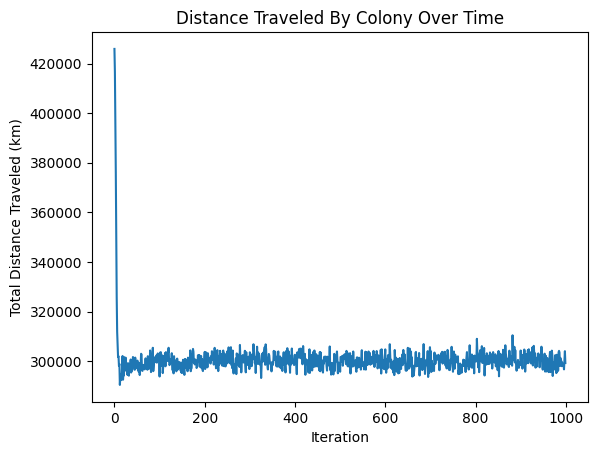

Best distance: 858.562 kms.
Run time : 32.144 seconds.


In [5]:
from matplotlib import pyplot as plot 
from statistics import mean as avg
from time import perf_counter as stopwatch

def create_line_graph(distance_record:list[float]):
    """ Display distance traveled by colony over its iterations.
    
    Args:
        distance_record : a list of the total distance traveled by all ants in colony
                          every iteration.
    Note:
        Prints to stdout in the form of a line graph.
    """
    # get iterations.
    iter_count = [i for i in range(len(distance_record))]
    
    # create, configure and dislay plot.
    plot.plot( iter_count, distance_record)
    plot.title('Distance Traveled By Colony Over Time')
    plot.xlabel('Iteration')
    plot.ylabel('Total Distance Traveled (km)')
    plot.show()

# config
seed = "Please Work"
ant_factor = float(10)
random_probability = .1
ph_evap_rate = .5
alpha = float(2)
beta = float(2)
stopping_condition = Stop.Iterations
cities = 25
iterations = 1000

start = stopwatch()
solution, distance_record = run_aso_algorithm(
                            seed,
                            ant_factor,
                            random_probability,
                            ph_evap_rate,
                            alpha,
                            beta,
                            stopping_condition,
                            cities,
                            iterations)
stop = stopwatch()
create_line_graph(distance_record)
print(f"Best distance: {solution['distance']} kms.")
print(f"Run time : {round((stop - start), 3)} seconds.")


### Woah..

That graph looks funky. Let's re-create it without the outlier values to get a clearer view of the trend. 

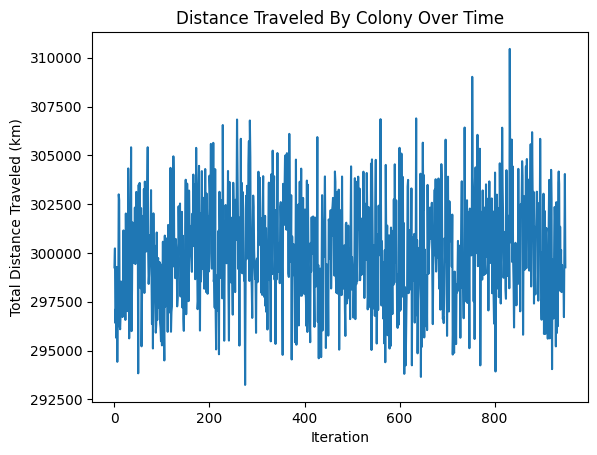

In [6]:
create_line_graph(distance_record[50:])

That's better. It looks like the first few iterations narrow the paths down considerably which is as expected. There also seems to be somewhat of a good balance between exploitation and exploration so, this configuration can be used as a baseline for comparison. 

Before running a large set of tests, let's also confirm the other stopping condition works as expected.

_Note_:
- Going forward, outlier values that minimize the readability of the graph will be removed as necessary.

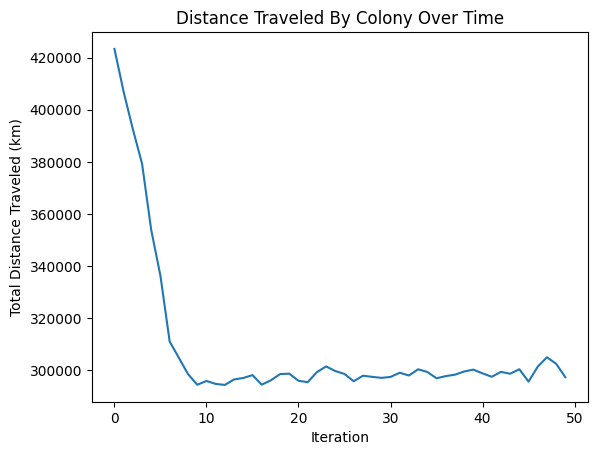

Best distance: 865.398 kms.
Run time : 1.614 seconds.


In [7]:
threshold_info = [.10, 50]
start = stopwatch()
sol, dr = run_aso_algorithm(
                            seed,
                            ant_factor,
                            random_probability,
                            ph_evap_rate,
                            alpha,
                            beta,
                            Stop.Threshold,
                            cities,
                            *threshold_info)
stop = stopwatch()
create_line_graph(dr)

print(f"Best distance: {sol['distance']} kms.")
print(f"Run time : {round((stop - start), 3)} seconds.")


### Interesting...

The threshold configuration returned similar results to the iteration based iteration-based configuration in a fraction of the time. This speaks volumes to the efficiency of the ASO algorithm. It also means that the algorithm will likely find its best solution in < 100 runs.

Now that those confirmations are out of the way, it's time to test! Considering the previous tests finished in < 1 minute, the next set of tests should't take a ridiculous amount of time (hopefully).


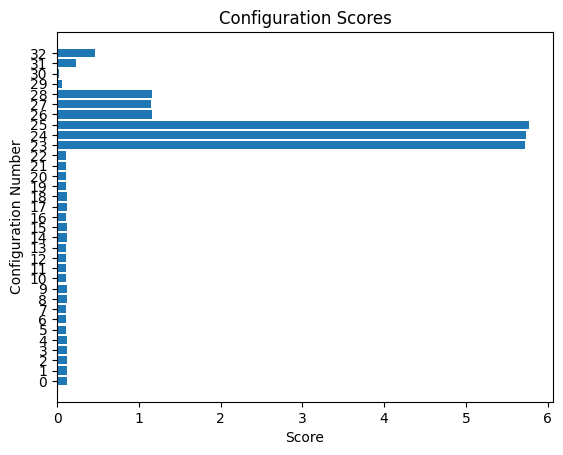

Best distance: 856.734 kms.
Average run time : 33.047 seconds.


In [8]:
def calculate_score(solution:float, iterations:int, formula: int):
    """Calculate a score for a configuration.
    
    Args:
        solution: the best solution found across all iterations.
        iterations : the number of iterations the configuration ran.
        formula : the formula option to use when calculating the score.
    Returns:
        A float representing the configuration's score calculated based off of the 
        best distance found and total iterations necessary of a configuration.
    """
    
    score = float(1000 / ( (iterations * .1 if formula == 1 else solution["ant"] * .01) * (solution["distance"] * .1) ) )
    
    return score

def create_bar_graph(config_scores: list[float]):
    """ Display the scores of each configuration.
    
    Args:
        config_scores : the order and scores of all configurations.
    Note:
        Prints to stdout in the form of a bar graph.
    """
                  
    positions = [i for i in range(len(config_scores))]
    scores = [score for score in config_scores]

    plot.barh(positions, scores)
    plot.yticks(positions, positions)
    plot.title('Configuration Scores')
    plot.xlabel('Score')
    plot.ylabel('Configuration Number')
    plot.show()

                  
SEED = "Please Work"
CITIES = 25

TEST_DATA = [
    # ant factor tests (1-3)
    {"ant_x" : 20, "rand_prob" : .1, "evap_x": .5, "a": 2, "b": 2, "stop": Stop.Iterations, "extra": [1000]},
    {"ant_x" : 30, "rand_prob" : .1, "evap_x": .5, "a": 2, "b": 2, "stop": Stop.Iterations, "extra": [1000]},
    {"ant_x" : 5, "rand_prob" : .1, "evap_x": .5, "a": 2, "b": 2, "stop": Stop.Iterations, "extra": [1000]},
    # random choice tests (4-6)
    {"ant_x" : 10, "rand_prob" : .2, "evap_x": .5, "a": 2, "b": 2, "stop": Stop.Iterations, "extra": [1000]},
    {"ant_x" : 10, "rand_prob" : .5, "evap_x": .5, "a": 2, "b": 2, "stop": Stop.Iterations, "extra": [1000]},
    {"ant_x" : 10, "rand_prob" : .05, "evap_x": .5, "a": 2, "b": 2, "stop": Stop.Iterations, "extra": [1000]},
    # pheromone evaporation rate tests (7-10)
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .6, "a": 2, "b": 2, "stop": Stop.Iterations, "extra": [1000]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .75, "a": 2, "b": 2, "stop": Stop.Iterations, "extra": [1000]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .3, "a": 2, "b": 2, "stop": Stop.Iterations, "extra": [1000]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .15, "a": 2, "b": 2, "stop": Stop.Iterations, "extra": [1000]},
    # alpha tests (11-16)
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 6, "b": 2, "stop": Stop.Iterations, "extra": [1000]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 4.5, "b": 2, "stop": Stop.Iterations, "extra": [1000]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 2.5, "b": 2, "stop": Stop.Iterations, "extra": [1000]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 1.5, "b": 2, "stop": Stop.Iterations, "extra": [1000]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": .75, "b": 2, "stop": Stop.Iterations, "extra": [1000]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": .5, "b": 2, "stop": Stop.Iterations, "extra": [1000]},
    # beta tests (17-22)
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 2, "b": 6, "stop": Stop.Iterations, "extra": [1000]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 2, "b": 4.5, "stop": Stop.Iterations, "extra": [1000]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 2, "b": 2.5, "stop": Stop.Iterations, "extra": [1000]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 2, "b": 1.5, "stop": Stop.Iterations, "extra": [1000]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 2, "b": .75, "stop": Stop.Iterations, "extra": [1000]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 2, "b": .5, "stop": Stop.Iterations, "extra": [1000]},
    # threshold condition tests (23-28)
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 2, "b": 2, "stop": Stop.Threshold, "extra": [.2, 20]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 2, "b": 2, "stop": Stop.Threshold, "extra": [.1, 20]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 2, "b": 2, "stop": Stop.Threshold, "extra": [.5, 20]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 2, "b": 2, "stop": Stop.Threshold, "extra": [.2, 100]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 2, "b": 2, "stop": Stop.Threshold, "extra": [.1, 100]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 2, "b": 2, "stop": Stop.Threshold, "extra": [.5, 100]},
    # iteration tests (29-32)
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 2, "b": 2, "stop": Stop.Iterations, "extra": [2000]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 2, "b": 2, "stop": Stop.Iterations, "extra": [5000]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 2, "b": 2, "stop": Stop.Iterations, "extra": [500]},
    {"ant_x" : 10, "rand_prob" : .1, "evap_x": .5, "a": 2, "b": 2, "stop": Stop.Iterations, "extra": [250]},

]

best_solution = solution
rel_scores = [calculate_score(solution, len(distance_record), 1)]
abs_scores = [calculate_score(solution, len(distance_record), 2)]
runtimes = []

for i, t in enumerate(TEST_DATA, start = 1):
    
    start = stopwatch()
    
    # run algorithm
    sol, dr = run_aso_algorithm(
                            SEED,
                            float(t["ant_x"]),
                            float(t["rand_prob"]),
                            float(t["evap_x"]),
                            float(t["a"]),
                            float(t["b"]),
                            t["stop"],
                            CITIES,
                            *t["extra"])
    runtimes.append(round((stopwatch() - start), 3))
    
    # save score data              
    rel_scores.append(calculate_score(sol, len(dr), 1))
    abs_scores.append(calculate_score(sol, len(dr), 2))
    
    if (min(best_solution["distance"], sol["distance"]) == sol["distance"]):
        best_solution = sol
                  
create_bar_graph(rel_scores)

print(f"Best distance: {best_solution['distance']} kms.")
print(f"Average run time : {round(avg(runtimes), 3)} seconds.")


### Final Thoughts/ Result Analysis

Compared to the genetic algorithm, the results are pretty precise. Instead, I think the more interesting metric to look at here is the efficiency of the algorithm using the various configurations. The 'best' distance calculated are similar enough to be considered a negligent factor.

The graph above, in a nutshell, shows how efficient a configuration is. That is how many iterations were ran in the configuraiton in relation to the best distance.

This graph is important because it supports the previous statement that the best distance is likely to be found in the first ~100 iterations. Here, we can see that the group of tests that relied on stopping the algorithm once the solution was not improving past a certain threshold received scores significantly higher than test that stopped after a (rather large) set amount of iterations. Likewise, the tests that used the threshold stopping condition with more iterations to improve their solution received far lower scores.

The next graph also supports this hypothesis, but more importantly, provides a absolute measurement of efficiency. It shows the scores of each configuration based on the best distance calculated in relation to the actual ant/iteration that found it, not the total iterations ran. Here, there's no particularly visible trend. This can most likely be attributed to the iteration-based configuration making minor (<1%) improvements to their best solution every 100 - 150 iterations. As expected, that configurations that vary the algorithm's exploration rate (ant's probability of choosing a random city) increased their scores considrably.

In conclusion, the ASO algorithm is a great option for optimization problems such as the TSP. It's substantially more efficient than the genetic algorithm as evident by its runtime and can calculate a "good" solution in far less time.

_Notes_ :
- The baseline solution is represented by point 0 in these graphs.

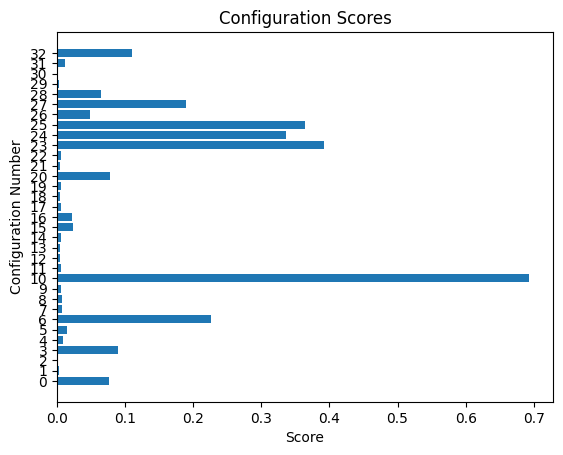

In [9]:
create_bar_graph(abs_scores)